In [123]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import logging
logging.basicConfig()

from pathlib import Path
from pprint import pprint

from tqdm import tqdm, trange

import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from scipy import ndimage as ndi
import skimage.morphology as morph

import fish

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [124]:
NOTEBOOK_NAME = "pipette"

HERE = Path.cwd().absolute()
DATA = HERE.parent / "data"
OUT = HERE / "out" / Path(NOTEBOOK_NAME).stem
print(HERE)
print(DATA)
print(OUT)

D:\projects\fish\dev
D:\projects\fish\data
D:\projects\fish\dev\out\pipette


In [125]:
frames = fish.cached_read(DATA / "C12-2.hsv")
frames.shape

DEBUG:fish.io:Cached read from D:\projects\fish\data\C12-2.hsv.cached


(1821, 1024, 1280)

In [126]:
bgnd = fish.background_via_min(frames)

Calculating background: 100%|██████████| 1821/1821 [00:09<00:00, 183.44it/s]


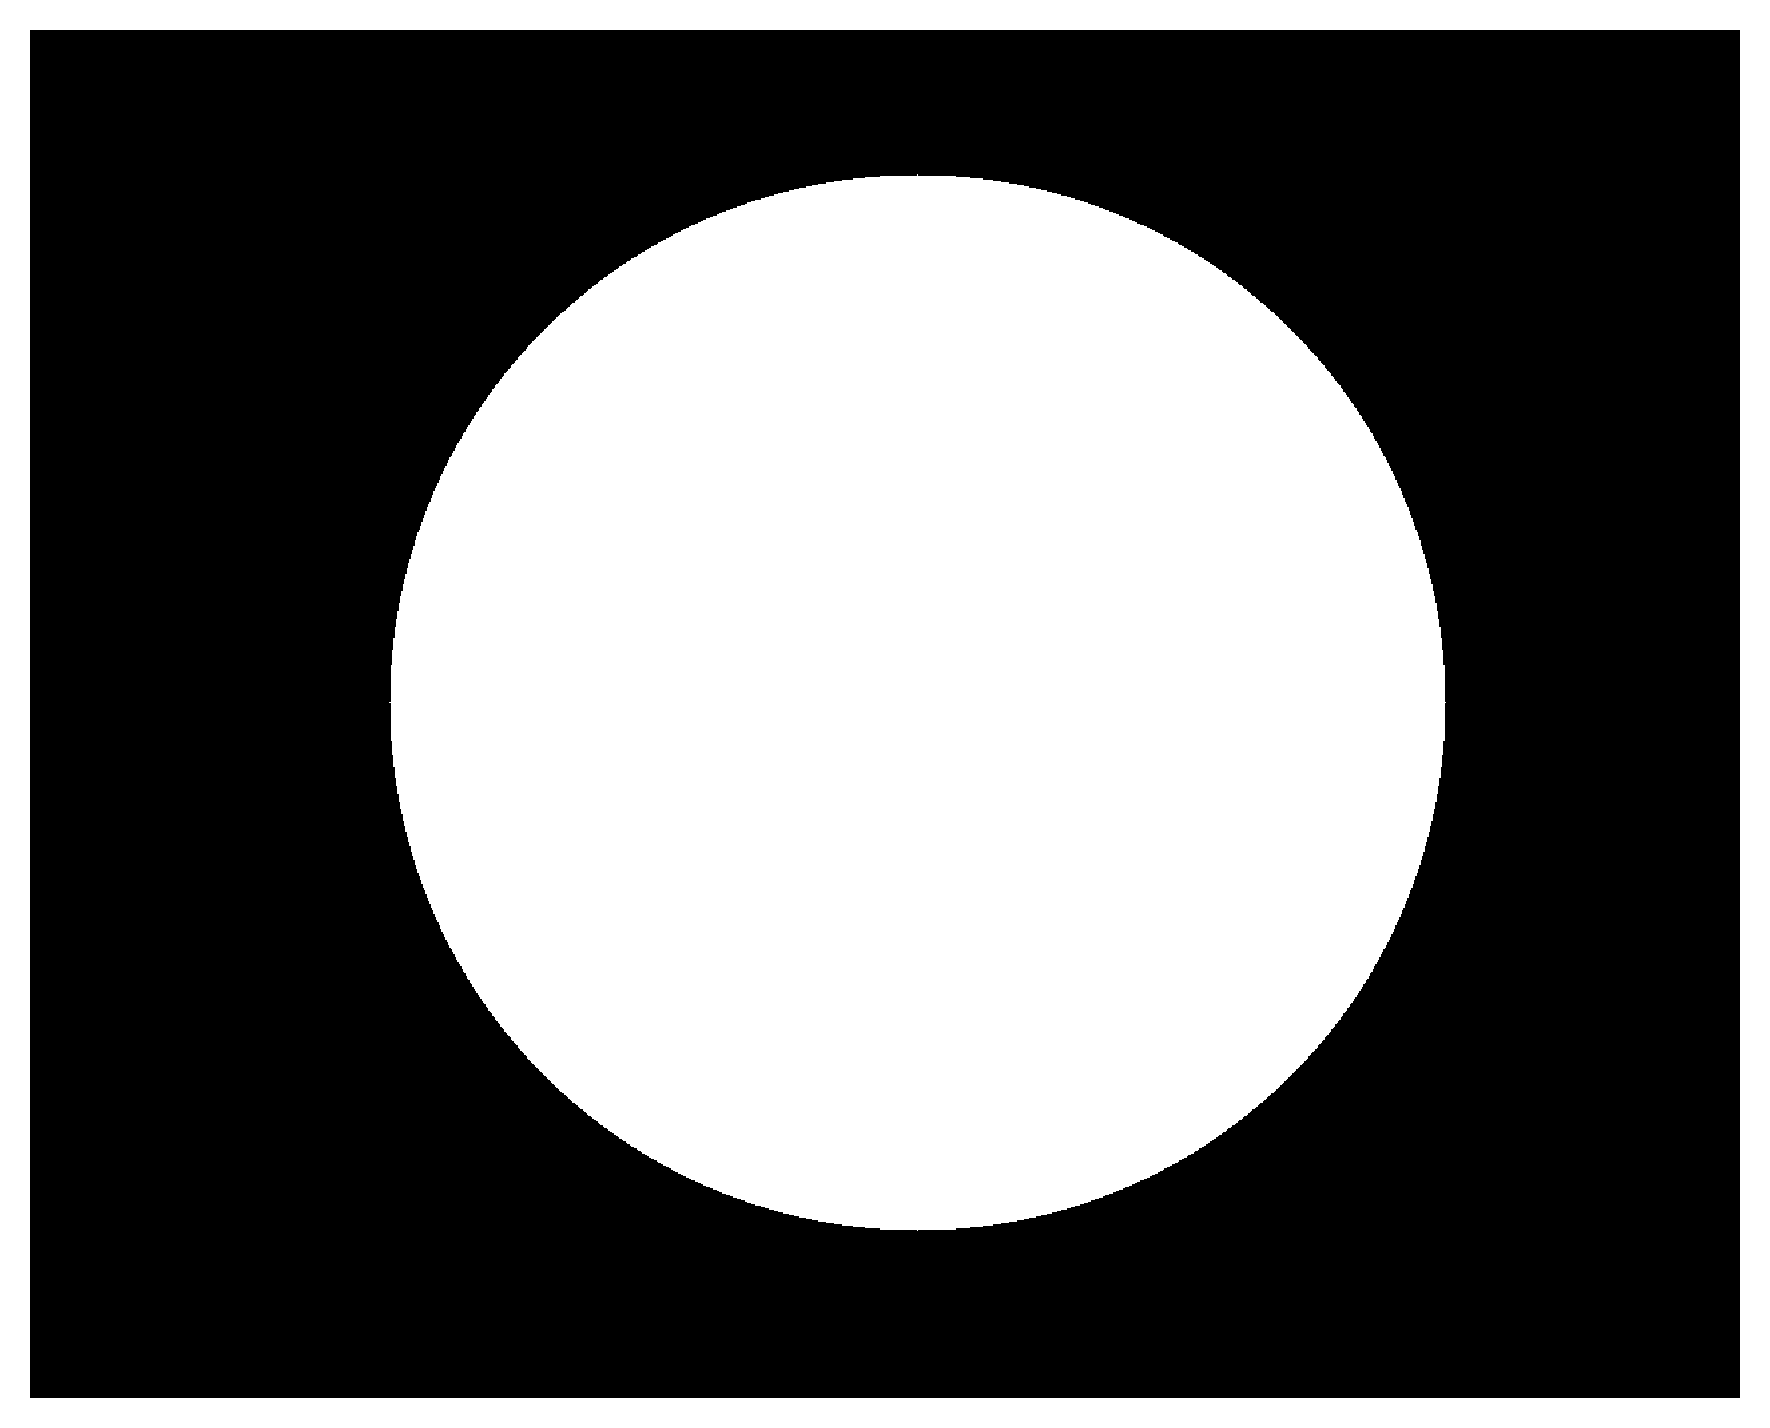

In [127]:
dish = fish.find_dish(bgnd)
mask = dish.mask_like(bgnd)

In [128]:
def label_largest_area(frame):
    without_bgnd = np.where(bgnd < frame, frame - bgnd, 0)
    masked = fish.apply_mask(without_bgnd, mask)
    thresh, thresholded = cv.threshold(masked, thresh = 0, maxval = 255, type = cv.THRESH_OTSU)
    
    with_edge = dish.draw_on(thresholded, start_angle = 0, end_angle = 90)
    inverted = cv.bitwise_not(with_edge)
    
    h, w = inverted.shape
    flood_mask = np.zeros((h + 2, w + 2), dtype = np.uint8)
    flood_mask[1:-1, 1:-1] = inverted
    
    _, flooded, b, _ = cv.floodFill(inverted, mask = flood_mask, seedPoint = (dish.x + dish.r, dish.y),
                                    newVal = 127,  flags = 8)
    
    return flooded

def size_of_largest_area(flooded):
    return np.count_nonzero(np.where(flooded == 127, 1, 0))
    
# fish.show_frame(label_largest_area(frames[30]))

In [129]:
areas = [size_of_largest_area(label_largest_area(frame)) for frame in tqdm(frames)]

100%|██████████| 1821/1821 [00:47<00:00, 38.08it/s]


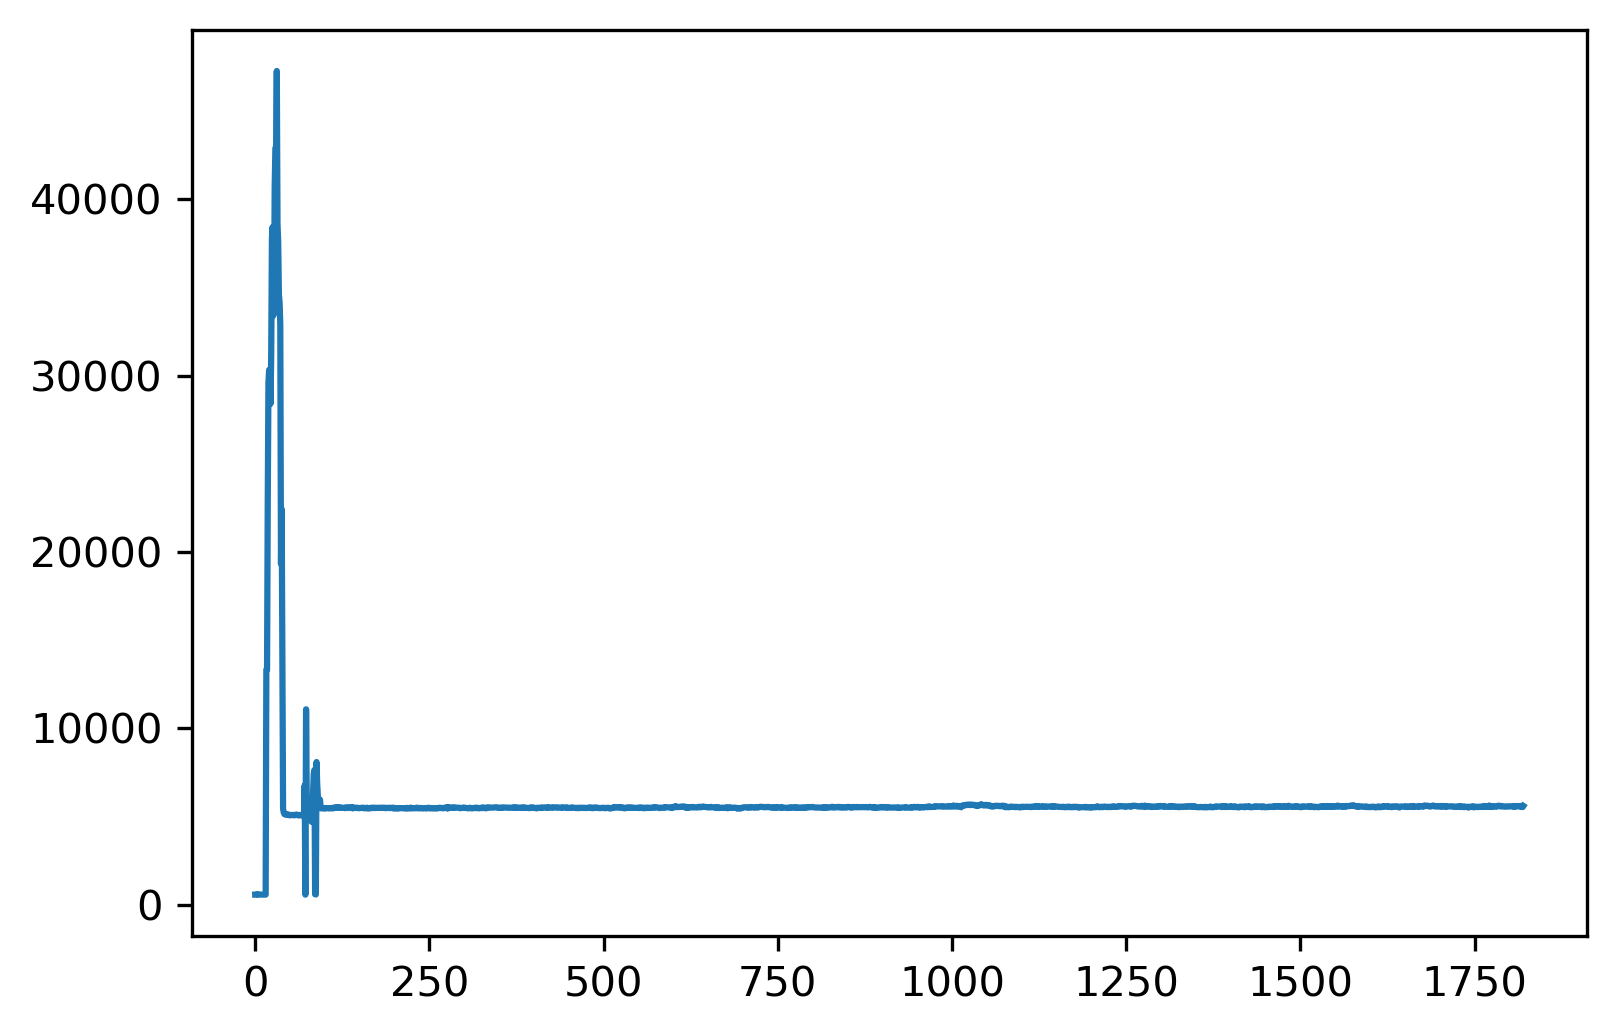

In [130]:
plt.close()
fig = plt.Figure(figsize = (6, 4), dpi = 300)
ax = fig.add_subplot(111)
ax.plot(areas)

fig

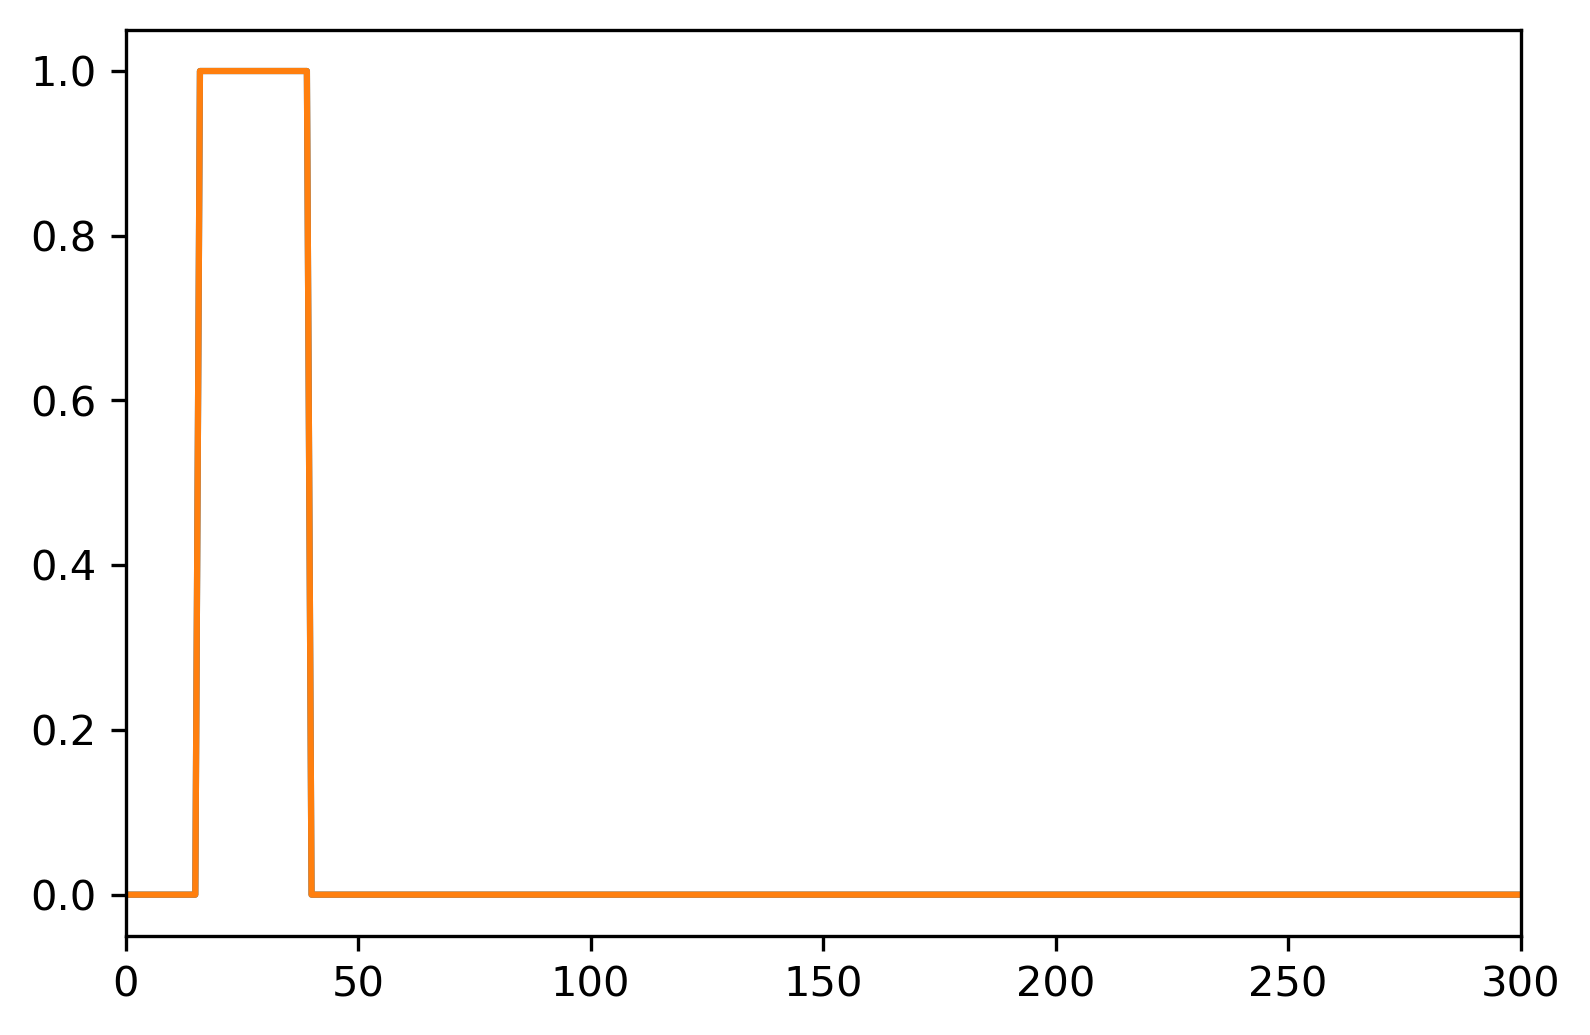

In [131]:
areas = np.array(areas)


thresh = areas > 2 * np.mean(areas)
closed = ndi.binary_closing(thresh, structure = np.array([1, 1, 1]), iterations = 3)

plt.close()
fig = plt.Figure(figsize = (6, 4), dpi = 300)
ax = fig.add_subplot(111)
ax.plot(thresh)
ax.plot(closed)

ax.set_xlim(0, 300)

fig

In [132]:
labels, num_features = ndi.measurements.label(closed)
print(num_features)
slices = ndi.measurements.find_objects(labels)
print(slices)
slices = [s[0] for s in slices]
pipette_slice = max(slices, key = lambda s: s.stop - s.start)
print(pipette_slice)
start_frame = pipette_slice.stop
print(start_frame)

1
[(slice(16, 40, None),)]
slice(16, 40, None)
40


In [133]:
f = frames[:100]
fish.make_movie(OUT / "test.mp4", (label_largest_area(frame) for frame in f), num_frames = len(f), fps = 2)

Writing frames to D:\projects\fish\dev\out\pipette\test.mp4: 100%|██████████| 100/100 [00:02<00:00, 39.95it/s]


WindowsPath('D:/projects/fish/dev/out/pipette/test.mp4')

In [134]:
fish.find_last_pipette_frame(frames, extra_frames = 0)

Calculating area of objects touching the disk...: 100%|██████████| 1821/1821 [00:49<00:00, 36.79it/s]


40